In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils.file_manager import load_scan, windowing_image
from utils.plot_manager import show_mask
from curve_util import *

dcm_file = "D:/2차년도/골이식재양/고대구로/네오/홍우선/술전"

_type, original_data, properties = load_scan(dcm_file)

tr_data = np.transpose(original_data, (2,1,0))
y = tr_data.shape[0]
top = bottom = 0
if _type == 1:
    top = y - 240
    bottom = y -140
    new_data = tr_data[top:bottom]
elif _type == 2:
    top = y-360
    bottom = y-250
    new_data = tr_data[top:bottom]
elif _type == 4:
    top = y-210
    bottom = y-150
    new_data = tr_data[top:bottom]
    

2 Tiles Stitching Data...


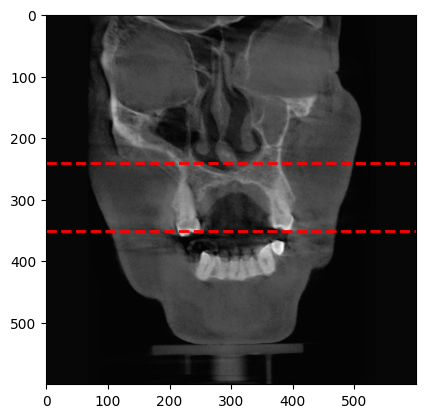

In [2]:
tmp_data = np.transpose(original_data, (1,2,0))
plt.imshow(tmp_data[120],'gray')
plt.axhline(top, 0, 1, color='red', linestyle='--', linewidth=2)
plt.axhline(bottom, 0, 1, color='red', linestyle='--', linewidth=2)

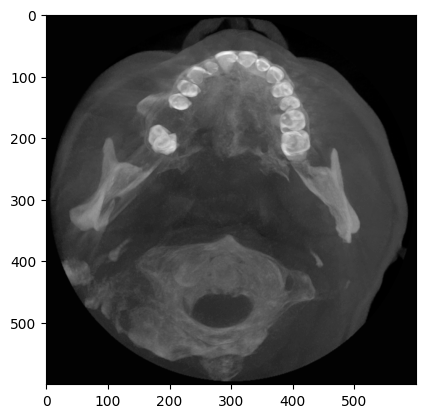

In [3]:
# Perform MIP along specified axis
mip_image = np.max(new_data, axis=0)
plt.imshow(mip_image, 'gray')

### Windowing and Normalize
---

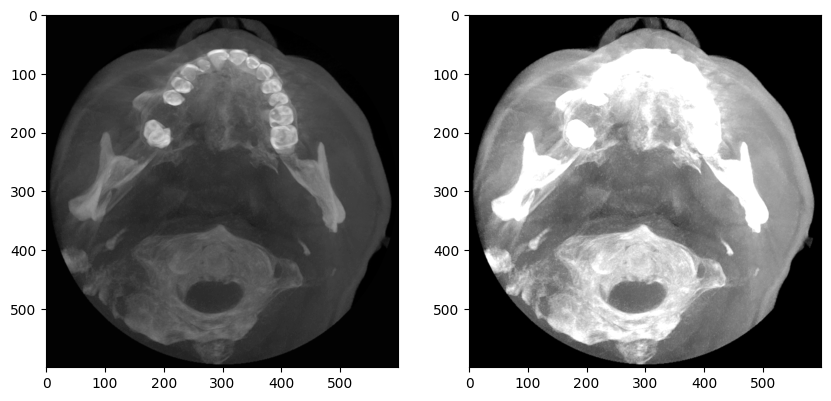

In [4]:
window_image = windowing_image(mip_image, properties, use_normalize=True)
bone_image = windowing_image(mip_image, properties,window=(700,3000), use_normalize=True)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(window_image, 'gray')
ax[1].imshow(bone_image, 'gray')

### Apply gamma
---

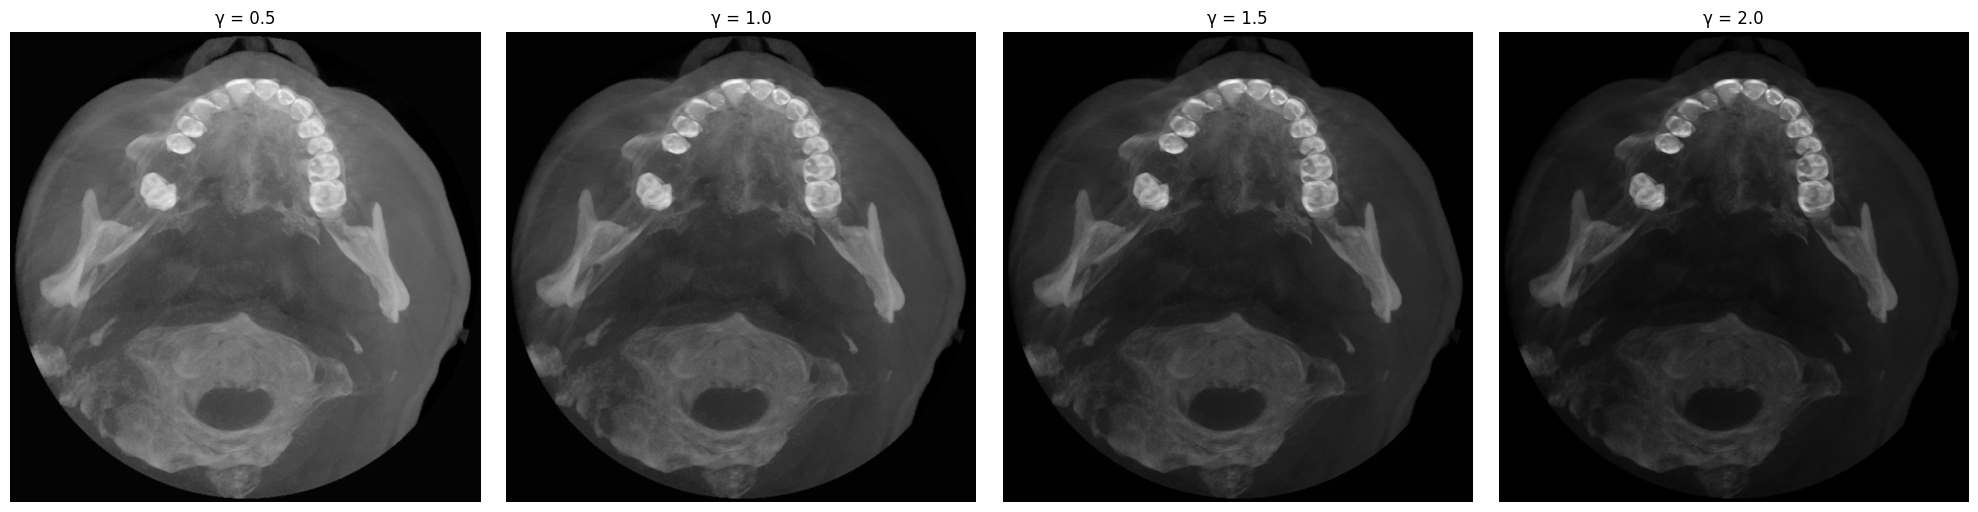

In [5]:
def visualize_gamma_effect(image, gammas=[0.5, 1.0, 1.5, 2.0]):
    """
    다양한 감마 값의 효과를 시각화하는 함수
    
    Parameters:
    -----------
    image : numpy.ndarray
        입력 이미지
    gammas : list of float
        테스트할 감마 값들의 리스트
    """
    fig, axes = plt.subplots(1, len(gammas), figsize=(5*len(gammas), 5))
    
    for ax, gamma in zip(axes, gammas):
        corrected = gamma_correction(image, gamma)
        ax.imshow(corrected, cmap='gray')
        ax.set_title(f'γ = {gamma}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
# 다양한 감마 값의 효과 시각화
visualize_gamma_effect(window_image)


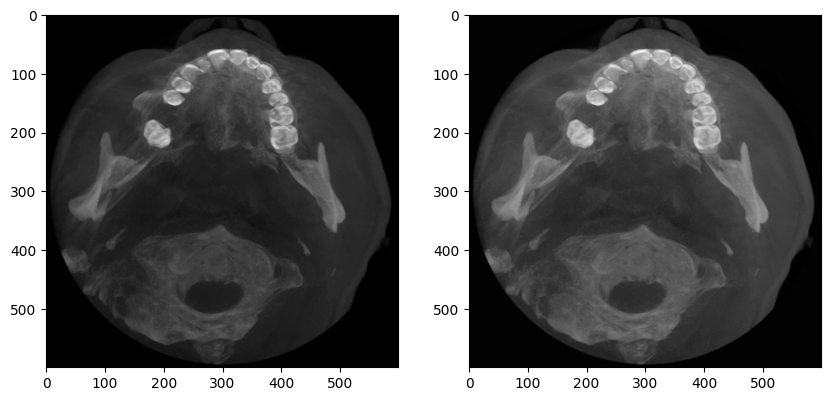

In [6]:
test_image = gamma_correction(window_image, gamma=1.5)
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(test_image,'gray')
ax[1].imshow(window_image, 'gray')

## Binarization
---

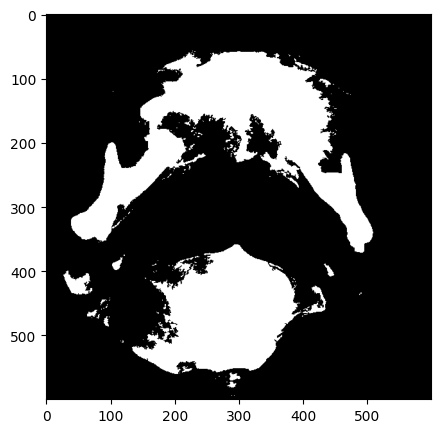

In [7]:
midle_point = (int(test_image.shape[0] / 2), int(test_image.shape[1] / 2))
seed_points = ([(0,0), midle_point])
binary_region = region_growing_binary(test_image, seed_points=seed_points, threshold=0.2)
# binary_region = invert_binary_image(binary_region)
# cleaned_binary = ~post_process_binary(binary_region, min_size=100)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(binary_region, 'gray')

### Segmented arch area
---

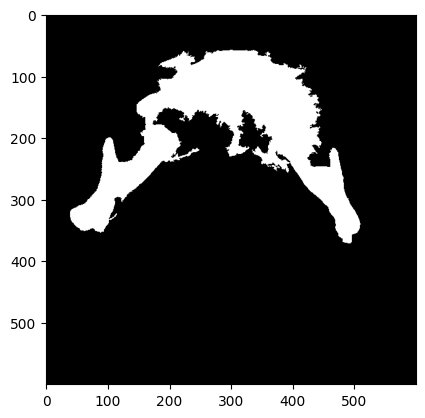

In [8]:
result, max_len = find_largest_component(binary_region)
plt.imshow(result, 'gray')

### The arch area after morphological
---

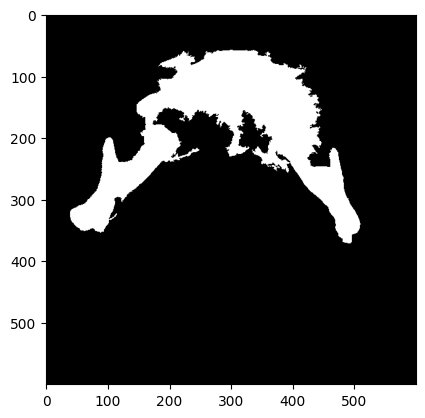

In [9]:
import scipy.ndimage as ndi
result_10 = ndi.binary_fill_holes(result)
# result_10 = fill_holes(result)
plt.imshow(result_10, 'gray')

### Apply Gaussian Filter
---

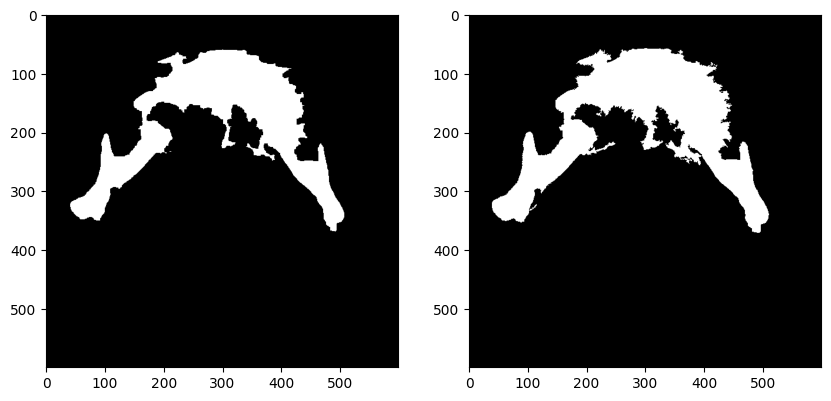

In [10]:

result_12 = smooth_edges(result_10, sigma=2.0, edge_width=2, iterations=2)
# result_12 = gaussian(result_10, sigma=2.0, mode="wrap")
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(result_12, 'gray')
ax[1].imshow(result_10, 'gray')

### skeletonize
---

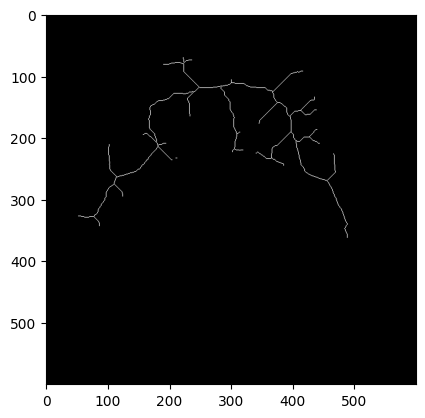

In [11]:
skeleton = extract_skeleton(result_12)
plt.imshow(skeleton, 'gray')

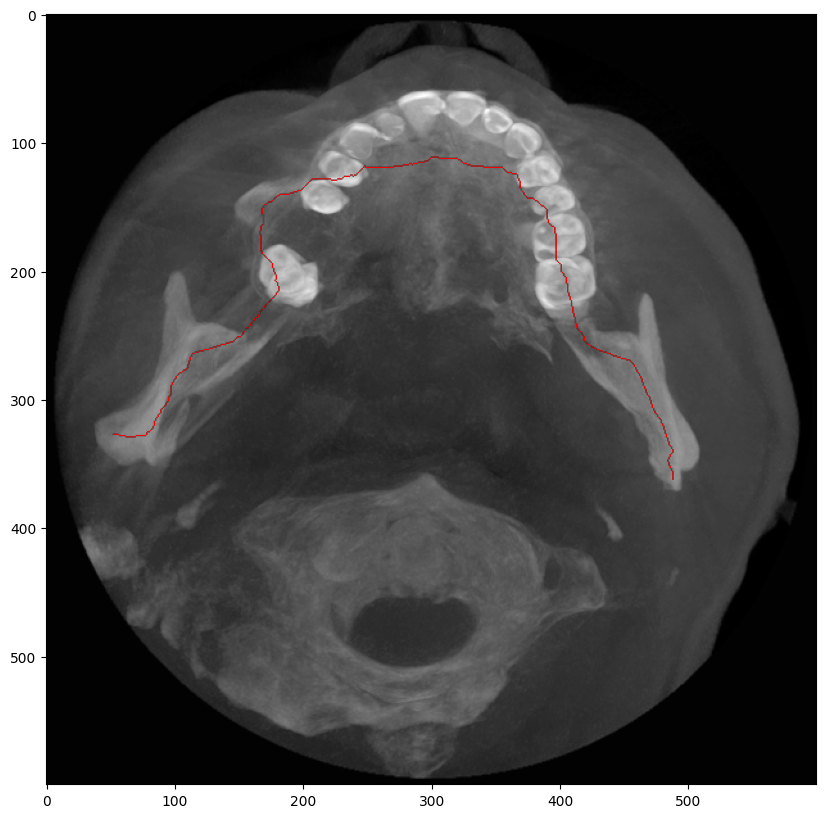

In [12]:
curve = find_longest_path(skeleton)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(mip_image, 'gray')
show_mask(curve, ax)